In [1]:
# ====== Fase 1: setup ======
# Import librerie
import os
import datetime as dt
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# Impostazioni generali
TICKERS = ["AAPL", "MSFT", "GOOG", "AMZN", "NVDA"]
START = "2018-01-01"
END = dt.date.today().strftime("%Y-%m-%d")

# Cartelle output
RAW_DIR = "data/raw"
PROC_DIR = "data/processed"
os.makedirs(RAW_DIR, exist_ok=True)
os.makedirs(PROC_DIR, exist_ok=True)

print(f"Tickers: {TICKERS}\nPeriodo: {START} → {END}")


Tickers: ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'NVDA']
Periodo: 2018-01-01 → 2025-08-13


In [2]:
# ====== Fase 1: download dati grezzi (MultiIndex) ======
# Manteniamo auto_adjust=False per avere esplicitamente il livello 'Adj Close'
data = yf.download(
    TICKERS,
    start=START,
    end=END,
    group_by="column",
    auto_adjust=False,
    progress=False,
    threads=True
)

# Salvataggio grezzo
raw_path = os.path.join(RAW_DIR, "multiticker_raw.csv")
data.to_csv(raw_path)
print("Salvato RAW:", raw_path)

# Ispezione colonne
print("\nPrimo livello colonne (tipi):", list(data.columns.levels[0]))
print("Esempio head():")
display(data.head())


Salvato RAW: data/raw\multiticker_raw.csv

Primo livello colonne (tipi): ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
Esempio head():


Price       Adj Close                                                 Close  \
Ticker           AAPL       AMZN       GOOG       MSFT      NVDA       AAPL   
Date                                                                          
2018-01-02  40.380993  59.450500  52.935345  79.328522  4.929085  43.064999   
2018-01-03  40.373966  60.209999  53.804180  79.697708  5.253488  43.057499   
2018-01-04  40.561497  60.479500  53.999023  80.399178  5.281181  43.257500   
2018-01-05  41.023312  61.457001  54.785843  81.395958  5.325933  43.750000   
2018-01-08  40.870934  62.343498  55.019955  81.479042  5.489126  43.587502   

Price                                                 ...       Open  \
Ticker           AMZN       GOOG       MSFT     NVDA  ...       AAPL   
Date                                                  ...              
2018-01-02  59.450500  53.250000  85.949997  4.98375  ...  42.540001   
2018-01-03  60.209999  54.124001  86.349998  5.31175  ...  43.132500   
2018-01-04  60.479500  54.320000  87.110001  5.33975  ...  43.134998   
2018-01-05  61.457001  55.111500  88.190002  5.38500  ...  43.360001   
2018-01-08  62.343498  55.347000  88.279999  5.55000  ...  43.587502   

Price                                                    Volume            \
Ticker           AMZN       GOOG       MSFT     NVDA       AAPL      AMZN   
Date                                                                        
2018-01-02  58.599998  52.417000  86.129997  4.89450  102223600  53890000   
2018-01-03  59.415001  53.215500  86.059998  5.10250  118071600  62176000   
2018-01-04  60.250000  54.400002  86.589996  5.39400   89738400  60442000   
2018-01-05  60.875500  54.700001  87.660004  5.35475   94640000  70894000   
2018-01-08  61.799999  55.111500  88.199997  5.51000   82271200  85590000   

Price                                      
Ticker          GOOG      MSFT       NVDA  
Date                                       
2018-01-02  24752000  22483800  355616000  
2018-01-03  28604000  26061400  914704000  
2018-01-04  20092000  21912000  583268000  
2018-01-05  25582000  23407100  580124000  
2018-01-08  20952000  22113000  881216000  

[5 rows x 30 columns]

In [3]:
# ====== Fase 1: estrazione viste 'wide' (Adj Close e Volume) ======
# In alcuni ambienti può capitare che 'Adj Close' non compaia (es. se auto_adjust=True).
# Facciamo un fallback intelligente.
level_names = data.columns.levels[0].tolist()

if "Adj Close" in level_names:
    adj_close_wide = data["Adj Close"].copy()
else:
    # Fallback: i Close sono spesso "adjusted" se si usa auto_adjust=True.
    # Qui lasciamo auto_adjust=False, quindi questo caso dovrebbe attivarsi raramente.
    print("⚠️ 'Adj Close' non presente: uso 'Close' come fallback.")
    adj_close_wide = data["Close"].copy()

if "Volume" in level_names:
    volume_wide = data["Volume"].copy()
else:
    volume_wide = pd.DataFrame(index=data.index)
    print("⚠️ 'Volume' non presente nei livelli.")

# Salvataggi processed
adj_path = os.path.join(PROC_DIR, "adj_close_wide.csv")
vol_path = os.path.join(PROC_DIR, "volume_wide.csv")
adj_close_wide.to_csv(adj_path)
volume_wide.to_csv(vol_path)
print("Salvati PROCESSED:", adj_path, " | ", vol_path)

display(adj_close_wide.head())


Salvati PROCESSED: data/processed\adj_close_wide.csv  |  data/processed\volume_wide.csv


Ticker,AAPL,AMZN,GOOG,MSFT,NVDA
Date,,,,,
2018-01-02,40.380993,59.450500,52.935345,79.328522,4.929085
2018-01-03,40.373966,60.209999,53.804180,79.697708,5.253488
2018-01-04,40.561497,60.479500,53.999023,80.399178,5.281181
2018-01-05,41.023312,61.457001,54.785843,81.395958,5.325933
2018-01-08,40.870934,62.343498,55.019955,81.479042,5.489126


In [4]:
# ====== Fase 1: controlli qualità mirati ======
qa_report = {}

# 1) Range date reale per ogni ticker
qa_report["date_min"] = adj_close_wide.min(axis=1).index.min()
qa_report["date_max"] = adj_close_wide.max(axis=1).index.max()

# 2) Ordinamento e duplicati indice
is_sorted = adj_close_wide.index.is_monotonic_increasing
dups = adj_close_wide.index.duplicated().sum()

# 3) NaN su Adj Close
nan_counts = adj_close_wide.isna().sum().to_dict()

# 4) Conteggio righe attese (ordine di grandezza)
rows = len(adj_close_wide)

print("=== QA REPORT ===")
print("Indice ordinato?:", is_sorted)
print("Duplicati nell'indice:", dups)
print("NaN per ticker:", nan_counts)
print("Righe totali (giorni di borsa):", rows)
print("Date range (indice):", adj_close_wide.index.min(), "→", adj_close_wide.index.max())

# Rimozione eventuali giorni completamente vuoti (tutti NaN)
adj_close_wide = adj_close_wide.dropna(how="all")


=== QA REPORT ===
Indice ordinato?: True
Duplicati nell'indice: 0
NaN per ticker: {'AAPL': 0, 'AMZN': 0, 'GOOG': 0, 'MSFT': 0, 'NVDA': 0}
Righe totali (giorni di borsa): 1913
Date range (indice): 2018-01-02 00:00:00 → 2025-08-12 00:00:00


In [5]:
# ====== Fase 1: esportazioni per-ticker (Date, Adj Close, Volume) ======
for t in TICKERS:
    df_t = pd.DataFrame({
        "Date": adj_close_wide.index,
        "Adj Close": adj_close_wide[t]
    })
    if t in volume_wide.columns:
        df_t["Volume"] = volume_wide[t]
    out_path = os.path.join(PROC_DIR, f"{t}.csv")
    df_t.to_csv(out_path, index=False)

print("Salvati file per-ticker in:", PROC_DIR)


Salvati file per-ticker in: data/processed


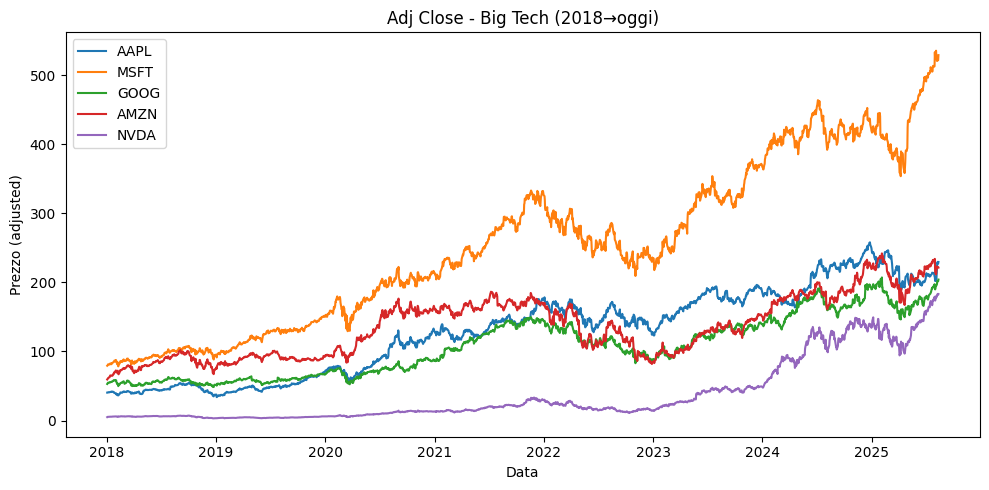

In [6]:
# ====== Fase 1: sanity plot veloce ======
plt.figure(figsize=(10,5))
for t in TICKERS:
    plt.plot(adj_close_wide.index, adj_close_wide[t], label=t)
plt.title("Adj Close - Big Tech (2018→oggi)")
plt.xlabel("Data")
plt.ylabel("Prezzo (adjusted)")
plt.legend()
plt.tight_layout()
plt.show()
